In [1]:
import numpy as np
import math
import copy
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
import SetPub
SetPub.set_pub()
np.random.seed(12211)  

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_funcs

In [2]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS'] # One file for each survey, minus primus -- not cool enough :P

n_epochs = 2000 #20
D = 5
K = 3 
learning_rate = 1e-5
decay_rate= 1e-3
batch_size = 1024
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [3]:
save_mod

'saved_hubs/tf2models/Train_UMnew_lr_1e-05_dr0.001_ne2000_k3_nt200000'

In [4]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [5]:
def minmax_cutsOBSarr(X, Xerr, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    # print( np.array(mask_cond).shape)
    X_new = X[mask_cond]
    X_err_new = Xerr[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    # print(X_new.shape)
    return X_new, X_err_new, y_new, l_new, mask_cond

In [6]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [7]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

## Perturb inputs

In [31]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188  -3.89   -2.103 -15.923  12.115]
ColMag-max:  [17.029  7.926  4.182  2.265 25.71 ]
----------


In [33]:
print(tf.__version__)

2.3.1


In [34]:
# Remove bad values
print(X_test.shape)
X_test, X_err, y_test, label_test = help_funcs.rm_bad_vals(X_test, X_err, y_test, label_test)
print(X_test.shape)

(4339, 5)
(3994, 5)


In [35]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, X_err, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, X_err, y_test, label_test)
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2551, 5)
Size of output in test data: (2551,)


In [37]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod) #

/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


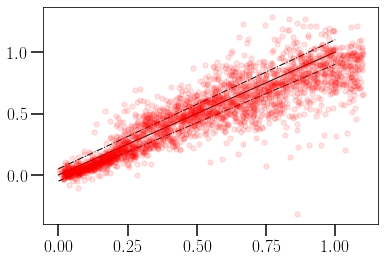

In [30]:
y_pred_mean, y_pred_std = help_funcs.predict(X_test, preproc, model_train)

fig, ax = plt.subplots()
#ax.scatter

ax.errorbar(y_test, preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0], # Inverse transform KNOWS what you did to get preproc_y :P
                 yerr= preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0], 
                 fmt='ro', ecolor='k', ms = 5, alpha = 0.1)
C = 0.05
z_t = np.array([0, 1])
z_tp = z_t + C*(1+z_t) # photo z's (predictions)
z_tm = z_t - C*(1+z_t) # spectroscopic z's (trues)

ax.plot(z_t, z_t, 'k')
ax.plot(z_t, z_tp, 'k-.')
ax.plot(z_t, z_tm, 'k-.')

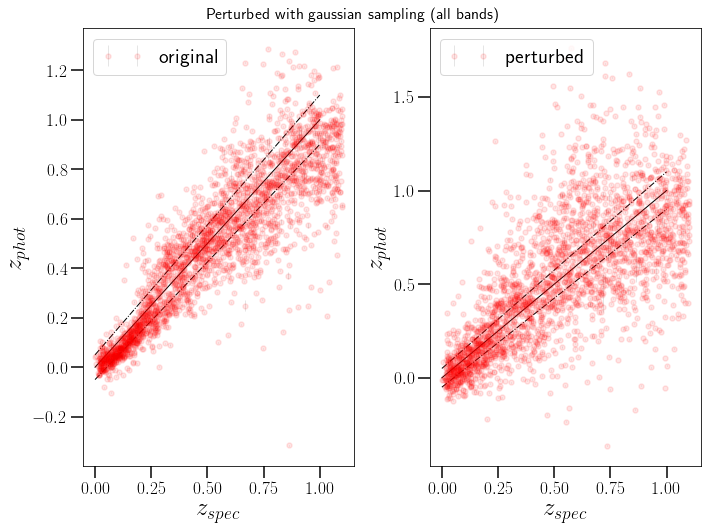

In [84]:
# Perturb one band (or multiple)
band_n = 4
delta_c = 0.95
approach = 'd'
prtb_X_test = help_funcs.perturb(X_test, band_n, delta_c = delta_c, approach = approach, X_err = X_err)
#print(prtb_X_test.shape)
#print(prtb_X_test)

# Compare perturbed and unperturbed predictions (mean and std-dev)
og_y_pred_mean, og_y_pred_std = help_funcs.predict(X_test, preproc, model_train)
prtb_y_pred_mean, prtb_y_pred_std = help_funcs.predict(prtb_X_test, preproc, model_train)

# Plot those comparisons
if approach != 'd':
    labels = ["original", "perturbed: " + str(band_n)]
else:
    labels = ["original", "perturbed"]
fig, axs = help_funcs.plot_side_by_sides(y_test, preproc_y, [og_y_pred_mean, prtb_y_pred_mean], [og_y_pred_std, prtb_y_pred_std], labels, approach, band_n, delta_c)

# Title and save
save = False
if save:
    if approach != 'd':
        suffix = "_deltac_" + str(delta_c) if approach == 'a' else ""
        fig.savefig(approach + "_compare_band_" + str(band_n) + suffix + ".png")
    else:
        fig.savefig("d_compare_all_bands" + ".png")
fig.show()

In [85]:
np.max(y_test)

1.0994

## Some new stuff from Nesar

So I guess y_test is Z_spec, and preproc_y (with all the fancy stuff) is Z_phot?

In [15]:
z_spec = y_test
z_pho = preproc_y.inverse_transform(prtb_y_pred_mean.reshape(-1, 1))[:, 0] # prtb or og
print(help_funcs.sigmaNMAD(z_spec, z_pho))
print(help_funcs.outlierFrac(z_spec, z_pho))

0.12708613008260727
73.3045864366915


In [16]:
help_funcs.sigmaNMAD(z_spec, z_pho)

0.12708613008260727

In [17]:
help_funcs.outlierFrac(z_spec, z_pho)

73.3045864366915

In [18]:
# what do these bins actually mean? I'm used to mass bins...
bins = np.linspace(0, 1, 20)
print(bins)
bincenter = (bins[1:] + bins[:-1]) / 2.
z_spec_digitize = np.digitize(z_spec, bins) # Return the indices of the bins to which each value in input array belongs. 
print(z_spec_digitize) # So nothing in bin 1? Why does it go 1 to 20 instead of 0 to 19?
print(len(z_spec_digitize))
sigmaNMAD_array = np.zeros(shape=bins.shape[0])
outFr_array = np.zeros(shape=bins.shape[0])

[0.    0.053 0.105 0.158 0.211 0.263 0.316 0.368 0.421 0.474 0.526 0.579
 0.632 0.684 0.737 0.789 0.842 0.895 0.947 1.   ]
[ 1  1  1 ... 20 20 20]
2551


In [19]:
for ind in range(bins.shape[0] - 1): # index?
    z_spec_bin_z =  z_spec[ z_spec_digitize  == ind + 1] # find the z_specs whose bin is ind + 1
    z_pho_bin_z =  z_pho[ z_spec_digitize  == ind + 1]   # find the z_phos whos bin is ind + 1 # why is this the same mask as based on z_spec?
    sigmaNMAD_array[ind] =  help_funcs.sigmaNMAD(z_spec_bin_z, z_pho_bin_z)
    outFr_array[ind] = help_funcs.outlierFrac(z_spec_bin_z, z_pho_bin_z, 0.15)

In [20]:
print(sigmaNMAD_array) # one entry for each bin
print(outFr_array)     # for first bin, z_specs are between 0 and 0.05, so most of the z_phos will be out of bounds
# so why do we care about the outFR's for anything except the largest bin?

[0.063 0.066 0.081 0.12  0.113 0.106 0.137 0.138 0.207 0.157 0.159 0.16
 0.168 0.167 0.119 0.127 0.134 0.15  0.142 0.   ]
[88.393 84.932 87.333 84.932 80.292 77.863 77.165 69.355 77.311 73.684
 72.059 80.488 78.195 66.102 60.345 60.194 63.063 63.366 58.12   0.   ]


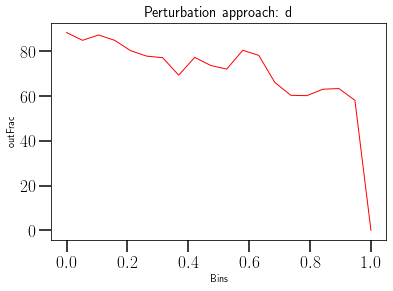

In [21]:
# Plot that!
check_sigma = False
fig, ax = plt.subplots()
if check_sigma:
    metric = sigmaNMAD_array
    ylab = "sigmaNMAD"
else:
    metric = outFr_array
    ylab = "outFrac"
ax.plot(bins, metric)
ax.set_xlabel("Bins")
ax.set_ylabel(ylab)
ax.set_title("Perturbation approach: " + approach)
fig.savefig(ylab + "_bins_" + approach + ".png")

### Now try perturbing lots of bands

<class 'numpy.ndarray'>
[0.022 0.008 0.003 ... 0.785 0.731 0.684]
5
Top of the morning to you
<class 'numpy.ndarray'>
[0.02  0.007 0.004 ... 0.762 0.733 0.71 ]
Top of the morning to you
<class 'numpy.ndarray'>
[0.023 0.009 0.003 ... 0.784 0.732 0.655]
Top of the morning to you
<class 'numpy.ndarray'>
[0.023 0.008 0.003 ... 0.739 0.731 0.688]
Top of the morning to you
<class 'numpy.ndarray'>
[0.021 0.008 0.004 ... 0.79  0.735 0.695]
Top of the morning to you
<class 'numpy.ndarray'>
[0.022 0.008 0.003 ... 0.784 0.731 0.685]


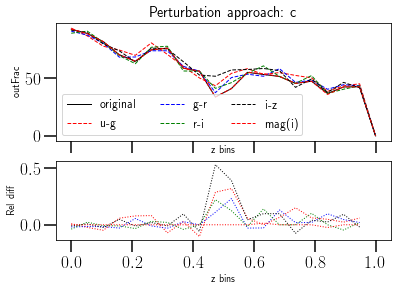

In [22]:
# Perturb lots of bands
approach = 'c' # b, c, or d # Not sure if d actually makes that much sense?
metric_name = "outFrac"
# Do I need x and y limits for these axes?
ncol = 3 # Should this actually be vertical and outside the plots, perhaps?

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})
colors = iter(["red", "blue", "green", "orange", "plum"]) # This isn't changing anything?
band_names = ["u-g", "g-r", "r-i", "i-z", "mag(i)"]

# Perturb the data
prtb_X_test_lst, prtb_y_pred_mean_lst, prtb_y_pred_std, og_y_pred_mean, og_y_pred_std = help_funcs.perturb_mult(X_test, X_err, preproc, model_train, approach) # why doesn't like help)funcs?

# Validate and plot og data first
og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.validate(y_test, og_y_pred_mean, preproc_y)
if metric_name == "sigma":
    og_metric = og_sigmaNMAD_array
elif metric_name == "outFrac":
    og_metric = og_outFr_array
fig, ax1 = help_funcs.plot_metric(og_metric, metric_name, approach, fig = fig, ax = ax1, label = "original", color = "black", linestyle = '-')
ax1.legend(ncol = ncol)

# Now plot the validations of the perturbed data
print(len(prtb_y_pred_mean_lst))
for i, y_pred_mean in enumerate(prtb_y_pred_mean_lst):
    print("Top of the morning to you")
    this_label = band_names[i]
    sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test, y_pred_mean, preproc_y) # How are you getting a different thing everytime when it's approach 'd'?
    if metric_name == "sigma":
        metric = sigmaNMAD_array
    elif metric_name == "outFrac":
        metric = outFr_array
    fig, ax1 = help_funcs.plot_metric(metric, metric_name, approach, fig = fig, ax = ax1, label = this_label, linestyle = '--')
    ax1.legend(ncol = ncol)
    
    # Look at relative difference
    relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
    ax2.plot(bins[:-1], relative_diff, linestyle = ":")
    ax2.set_ylabel("Rel diff")
    ax2.set_xlabel("z bins")
    
fig.savefig(metric_name + "_approach_" + approach + "_rel" + ".png")

### Special version for approach 'a'

<class 'numpy.ndarray'>
[0.022 0.008 0.003 ... 0.785 0.731 0.684]
<class 'numpy.ndarray'>
[ 0.017 -0.003 -0.005 ...  0.786  0.732  0.692]
<class 'numpy.ndarray'>
[ 0.013 -0.013 -0.012 ...  0.787  0.734  0.699]
<class 'numpy.ndarray'>
[ 0.007 -0.033 -0.027 ...  0.791  0.74   0.714]
<class 'numpy.ndarray'>
[ 4.123e-04 -5.091e-02 -4.240e-02 ...  7.944e-01  7.443e-01  7.283e-01]
<class 'numpy.ndarray'>
[-0.004 -0.068 -0.056 ...  0.798  0.747  0.742]
<class 'numpy.ndarray'>
[-0.009 -0.084 -0.072 ...  0.803  0.751  0.755]
<class 'numpy.ndarray'>
[0.022 0.008 0.003 ... 0.785 0.731 0.684]
<class 'numpy.ndarray'>
[0.028 0.022 0.01  ... 0.785 0.721 0.669]
<class 'numpy.ndarray'>
[0.035 0.037 0.018 ... 0.787 0.712 0.654]
<class 'numpy.ndarray'>
[0.052 0.073 0.036 ... 0.781 0.698 0.628]
<class 'numpy.ndarray'>
[0.068 0.11  0.062 ... 0.758 0.681 0.604]
<class 'numpy.ndarray'>
[0.085 0.145 0.089 ... 0.73  0.652 0.585]
<class 'numpy.ndarray'>
[0.102 0.178 0.116 ... 0.692 0.618 0.563]
<class 'numpy.nd

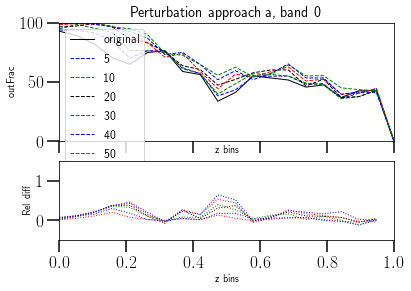

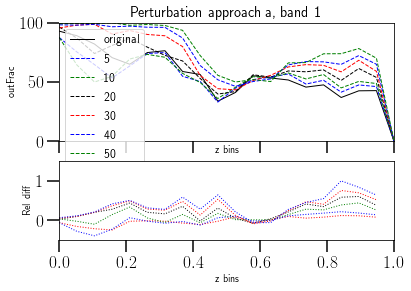

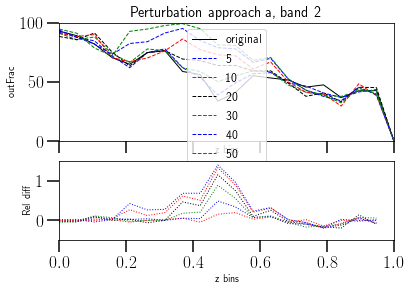

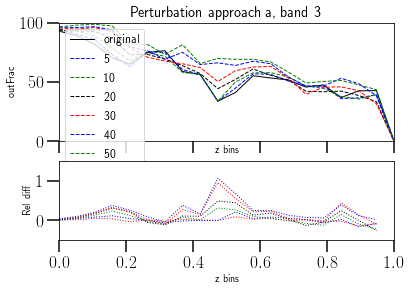

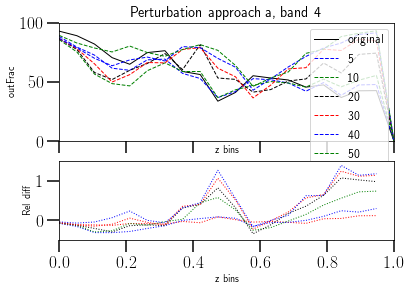

In [23]:
# For approach a, perturb each band by 5 delta_c's between 5 and 50%. Plot each of those outcomes (one plot per band)
approach = 'a'
metric_name = "outFrac"
delta_c = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
sigma_y_lims = [0,0.35]
sigma_y_lims_rel = [-1,5]
outFr_y_lims = [0,100]
outFr_y_lims_rel = [-0.5,1.5]

for band_n in [0, 1, 2, 3, 4]:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})
    # Start with original
    og_y_pred_mean, og_y_pred_std = help_funcs.predict(X_test, preproc, model_train)
    og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.validate(y_test, og_y_pred_mean, preproc_y) #preproc or preproc_y?
    if metric_name == "sigma":
        og_metric = og_sigmaNMAD_array
        y_lims = sigma_y_lims
        y_lims_rel = sigma_y_lims_rel
    elif metric_name == "outFrac":
        og_metric = og_outFr_array
        y_lims = outFr_y_lims
        y_lims_rel = outFr_y_lims_rel
    fig, ax1 = help_funcs.plot_metric(og_metric, metric_name, approach, band_n, fig = fig, ax = ax1, label = "original", color = "black")
    ax1.legend()
    
    # Now perturb
    prtb_X_test_lst = help_funcs.perturb(X_test, band_n, delta_c, approach, X_err = X_err)
    for i, prtb_X_test in enumerate(prtb_X_test_lst):
        prtb_y_pred_mean, prtb_y_pred_std = help_funcs.predict(prtb_X_test, preproc, model_train)
        this_label = str(math.trunc((delta_c[i] - 1)*100 + 0.5)) + "%"

        sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test, prtb_y_pred_mean, preproc_y)
        if metric_name == "sigma":
            metric = sigmaNMAD_array
        elif metric_name == "outFrac":
            metric = outFr_array
        fig, ax1 = help_funcs.plot_metric(metric, metric_name, approach, band_n, fig = fig, ax = ax1, label = this_label, linestyle = '--')
        ax1.legend()
    
        # Look at relative difference
        relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
        #print(relative_diff)
        ax2.plot(bins[:-1], relative_diff, linestyle = ":")
        ax2.set_ylabel("Rel diff")
        ax2.set_xlabel("z bins")
    
    
    ax1.set_ylim(y_lims[0],y_lims[1])
    ax1.set_xlim(0,1)
    ax2.set_ylim(y_lims_rel[0],y_lims_rel[1])
    ax2.set_xlim(0,1)
    fig.savefig(metric_name + "_" + approach + "_band_" + str(band_n) + "_rel" + ".png")
    fig.show()

<class 'numpy.ndarray'>
[0.022 0.008 0.003 ... 0.785 0.731 0.684]
5
<class 'numpy.ndarray'>
[0.077 0.051 0.041 ... 0.568 0.906 0.715]


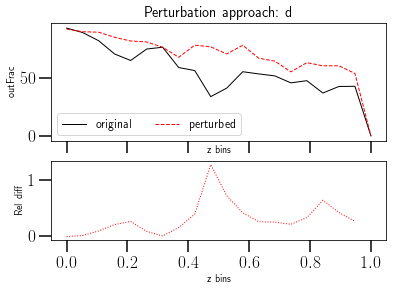

In [24]:
# Special version for approach d (???)
# Perturb lots of bands
approach = 'd' # b, c, or d # Not sure if d actually makes that much sense?
metric_name = "outFrac"
# Do I need x and y limits for these axes?
ncol = 3 # Should this actually be vertical and outside the plots, perhaps?

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})

# Perturb the data
prtb_X_test = help_funcs.perturb(X_test, approach = approach, X_err = X_err)
prtb_y_pred_mean, prtb_y_pred_std = help_funcs.predict(prtb_X_test, preproc, model_train)
og_y_pred_mean, og_y_pred_std = help_funcs.predict(X_test, preproc, model_train)

# Validate and plot og data first
og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.validate(y_test, og_y_pred_mean, preproc_y)
if metric_name == "sigma":
    og_metric = og_sigmaNMAD_array
elif metric_name == "outFrac":
    og_metric = og_outFr_array
fig, ax1 = help_funcs.plot_metric(og_metric, metric_name, approach, fig = fig, ax = ax1, label = "original", color = "black", linestyle = '-')
ax1.legend(ncol = ncol)

# Now plot the validations of the perturbed data
print(len(prtb_y_pred_mean_lst))
sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test, prtb_y_pred_mean, preproc_y) # How are you getting a different thing everytime when it's approach 'd'?
if metric_name == "sigma":
    metric = sigmaNMAD_array
elif metric_name == "outFrac":
    metric = outFr_array
fig, ax1 = help_funcs.plot_metric(metric, metric_name, approach, fig = fig, ax = ax1, label = "perturbed", linestyle = '--')
ax1.legend(ncol = ncol)

# Look at relative difference
relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
ax2.plot(bins[:-1], relative_diff, linestyle = ":")
ax2.set_ylabel("Rel diff")
ax2.set_xlabel("z bins")
    
fig.savefig(metric_name + "_approach_" + approach + "_rel" + ".png")

### Also, consider plotting some pdfs

In [67]:
def gaussian_pdf(zgrid, mean, std):
    pdf = stats.norm.pdf(zgrid, mean, std) # interesting, I don't think I've ever made a pdf this way (I've always done a normalized continuous histogram, I guess)
    return pdf
def mdn_pdf(zgrid, y_pred_3weights, y_pred_3means, y_pred_3stds):
    mix_pdf = np.zeros_like(zgrid)
    for icomp in range(y_pred_3weights.shape[0]):
        mix_pdf += gaussian_pdf(zgrid, y_pred_3means[icomp], y_pred_3stds[icomp]) * y_pred_3weights[icomp]
    sum_pz = np.sum(mix_pdf)#[:,None]
    mix_pdf/=sum_pz
    return mix_pdf

In [68]:
# Might have to change this one a little bit :P
galID = 22#23#65
Xt = X_test[sel].copy() # How would I import this?
Xt = preproc.transform(Xt[galID][None, :]) # I guess transform is a function of preproc, which already exists?
y_pred = np.array(model_train(Xt))
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])[0]
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))[0]
y_pred_3weights = y_pred[2, :, :][0]

# Gaussian meshes?
gm1 = gaussian_pdf(zgrid, y_pred_3means[0], y_pred_3std[0])
gm1/=np.sum(gm1)
gm2 = gaussian_pdf(zgrid, y_pred_3means[1], y_pred_3std[1])
gm2/=np.sum(gm2)
gm3 = gaussian_pdf(zgrid, y_pred_3means[2], y_pred_3std[2])
gm3/=np.sum(gm3)
pdf = mdn_pdf(zgrid, y_pred_3weights, y_pred_3means, y_pred_3std)

# Do the actual plotting
f, ax = plt.subplots(2,1, figsize = (10, 12))
ax[0].plot(zgrid, gm1, '-.', label = 'Component =1')
ax[0].plot(zgrid, gm2, '-.', label = 'Component =2')
ax[0].plot(zgrid, gm3, '-.', label = 'Component =3')
ax[1].plot(zgrid, pdf, label = 'MDN at mean-colors')
ax[1].plot(zgrid, pz[galID], label = 'Sampled')
ax[0].axvline( y_test[sel][galID], color='k', linestyle = 'dashed', label='Target redshift')
ax[1].axvline( y_test[sel][galID], color='k', linestyle = 'dashed', label='Target redshift')
ax[0].legend()
ax[1].legend()
  # plt.axvline(y_train[-i], color='k', linestyle = 'dashed', label='True value')
  # plt.xscale('log')
ax[0].set_xlabel(r'$z$')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$p(z|c)$')
ax[1].set_ylabel(r'$p(z|c)$')
plt.show()

NameError: name 'sel' is not defined

### Other stuff

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using

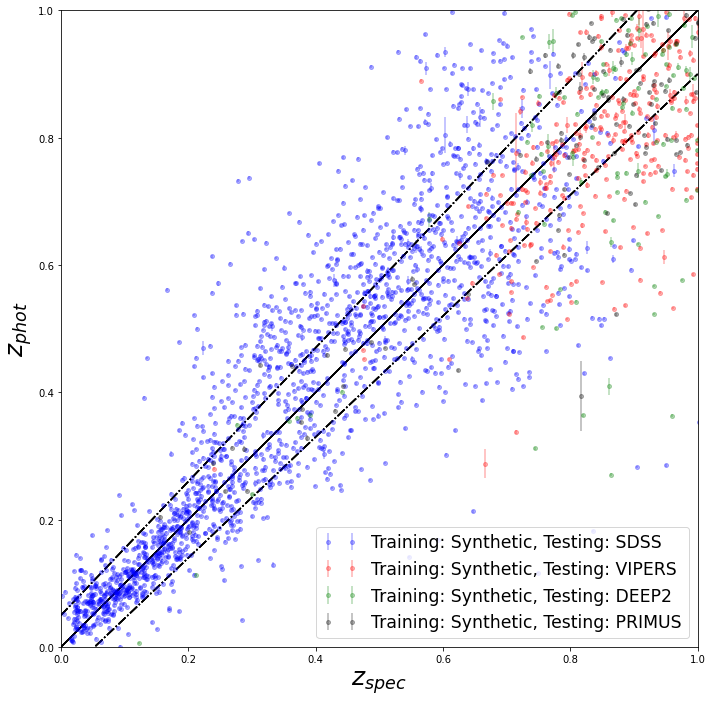

In [51]:
## Plotting survey-based predictions. With a manually set offset 
offset = 0.04


for label_ind in [0, 1, 2, 3]:
    plt.figure(22,figsize=(10, 10,)) 
    colorstring = ['b', 'r', 'g', 'k']
    surveyindx = np.where(label_test == label_ind) # same idea as sel and sel_ind
    
    plt.errorbar(y_test[surveyindx], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0],
                 yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0],
                 fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind],
                 c = colorstring[label_ind])

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)
    plt.plot(z_t, z_t, 'k')
    plt.plot(z_t, z_tp, 'k-.')
    plt.plot(z_t, z_tm, 'k-.')

    plt.ylabel(r'$z_{phot}$', fontsize=25)
    plt.xlabel(r'$z_{spec}$', fontsize=25)
    plt.xlim(0.0, 1)
    plt.ylim(0.0, 1)
    plt.tight_layout()
    plt.axes().set_aspect('equal')
    leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

## Old-ish stuff

In [ ]:
## Prediction 
X_test = preproc.transform(X_test)
y_pred = np.array(model_train(X_test))

In [ ]:
## Best prediction (mean and std) of the Gaussian mixture is taken as the the one with highest weight
y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0])

In [ ]:
## Plotting mean and std-dev of predictions. The bias in prediction is clearly seen (esp at low-z)
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std

plt.figure(figsize=(10, 10))

plt.errorbar(y_test, preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0], 
             yerr= preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0], 
             fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

C = 0.05
z_t = np.array([0, 1])
z_tp = z_t + C*(1+z_t)
z_tm = z_t - C*(1+z_t)
plt.plot(z_t, z_t, 'k')
plt.plot(z_t, z_tp, 'k-.')
plt.plot(z_t, z_tm, 'k-.')
plt.ylabel(r'$z_{phot}$', fontsize=25)
plt.xlabel(r'$z_{spec}$', fontsize=25)
plt.tight_layout()
plt.axes().set_aspect('equal')
leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()